# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

import phik

In [2]:
RANDOM_STATE = 42

## Загрузка и подготовка данных

### Загрузка

In [3]:
def pd_read_csv_wrap(
    bname,
    *args,
    **kwargs
):
    '''
    обёртка для pd.read_csv
    '''
    df = pd.read_csv(
        f'{bname}.csv',
        *args,
        **kwargs
    )
    
    df.columns.name = bname
    
    display(df.info())
    display(df.head())
    
    return df

In [4]:
geo_data_0 = pd_read_csv_wrap('geo_data_0')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

geo_data_0,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_1 = pd_read_csv_wrap('geo_data_1')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

geo_data_1,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_data_2 = pd_read_csv_wrap('geo_data_2')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

geo_data_2,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные загрузились нормально, типы данных определились корректно, пропусков нет.

### Предобработка

In [7]:
for df in geo_data_0, geo_data_1, geo_data_2:
    
    print(f'\n=== {df.columns.name} ===\n')
    
    print('Пропуски')
    display(df.isna().sum())
    
    print('Полные дубликаты')
    display(df.duplicated().sum())
    
    print('Дубликаты по id')
    display(df.duplicated(subset=['id']).sum())


=== geo_data_0 ===

Пропуски


geo_data_0
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Полные дубликаты


0

Дубликаты по id


10


=== geo_data_1 ===

Пропуски


geo_data_1
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Полные дубликаты


0

Дубликаты по id


4


=== geo_data_2 ===

Пропуски


geo_data_2
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Полные дубликаты


0

Дубликаты по id


4

Пропусков действительно нет, полных дубликатов тоже. Есть сроки с одинаковым id - надо разбираться.

In [8]:
for df in geo_data_0, geo_data_1, geo_data_2:
    
    print(f'\n=== {df.columns.name} ===\n')
        
    print('Дубликаты по id')
    display(df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id'))


=== geo_data_0 ===

Дубликаты по id


geo_data_0,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



=== geo_data_1 ===

Дубликаты по id


geo_data_1,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



=== geo_data_2 ===

Дубликаты по id


geo_data_2,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Все записи с одинаковыми id характеризуются разными f0, f1 и f2 - очень странно, вероятно ошибка.
Доля таких записей в датасетах меньше 0.02% - выбросим все во избежание проблем.

In [9]:
for df in geo_data_0, geo_data_1, geo_data_2:
    df.drop_duplicates(subset=['id'], keep=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

Теперь порядок

### Исследовательский анализ

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


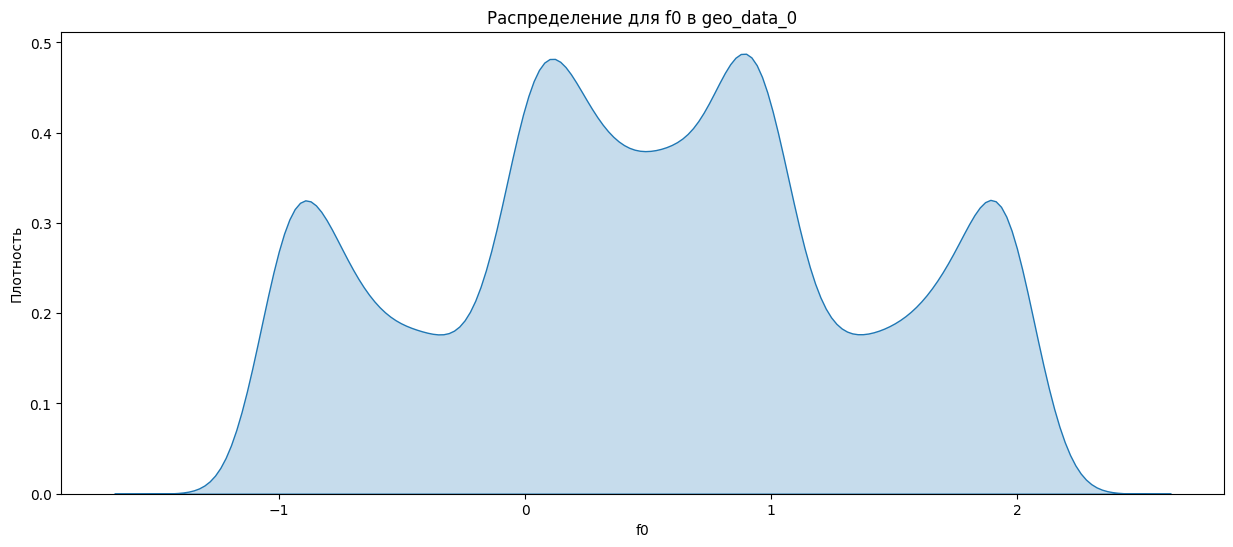

count    99980.000000
mean         0.500447
std          0.871879
min         -1.408605
25%         -0.072674
50%          0.502374
75%          1.073692
max          2.362331
Name: f0, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


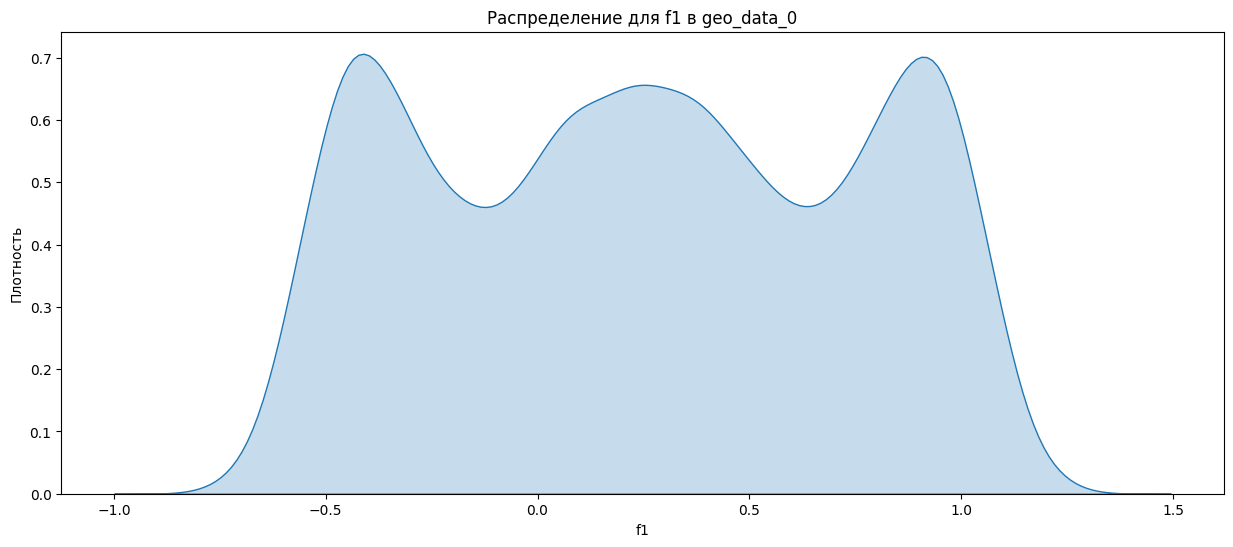

count    99980.000000
mean         0.250147
std          0.504431
min         -0.848218
25%         -0.200869
50%          0.250252
75%          0.700646
max          1.343769
Name: f1, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


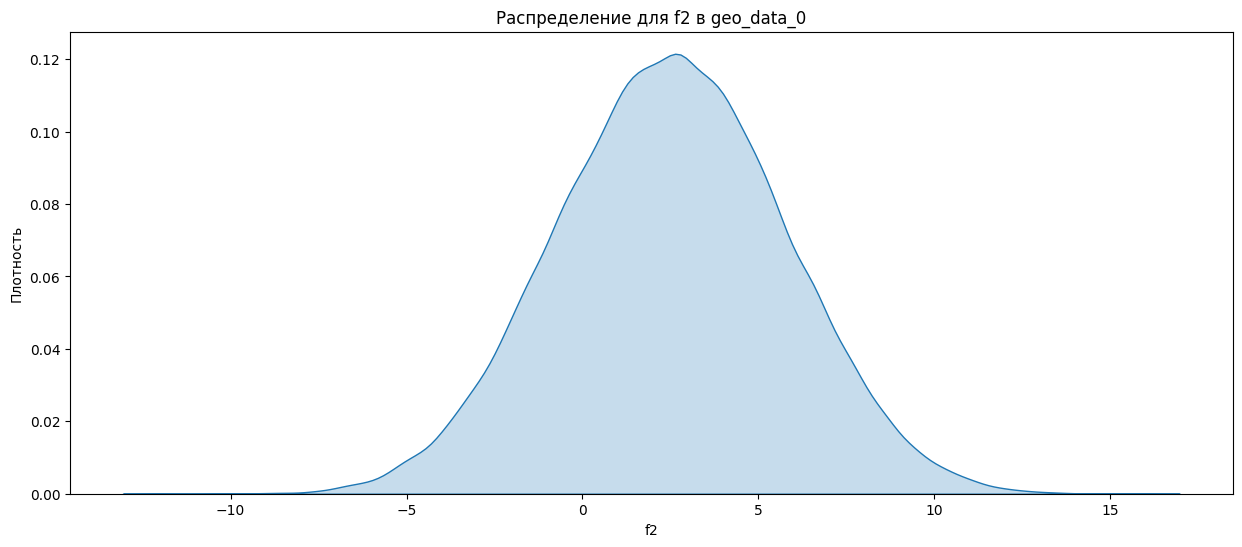

count    99980.000000
mean         2.502638
std          3.248056
min        -12.088328
25%          0.288010
50%          2.516005
75%          4.714884
max         16.003790
Name: f2, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


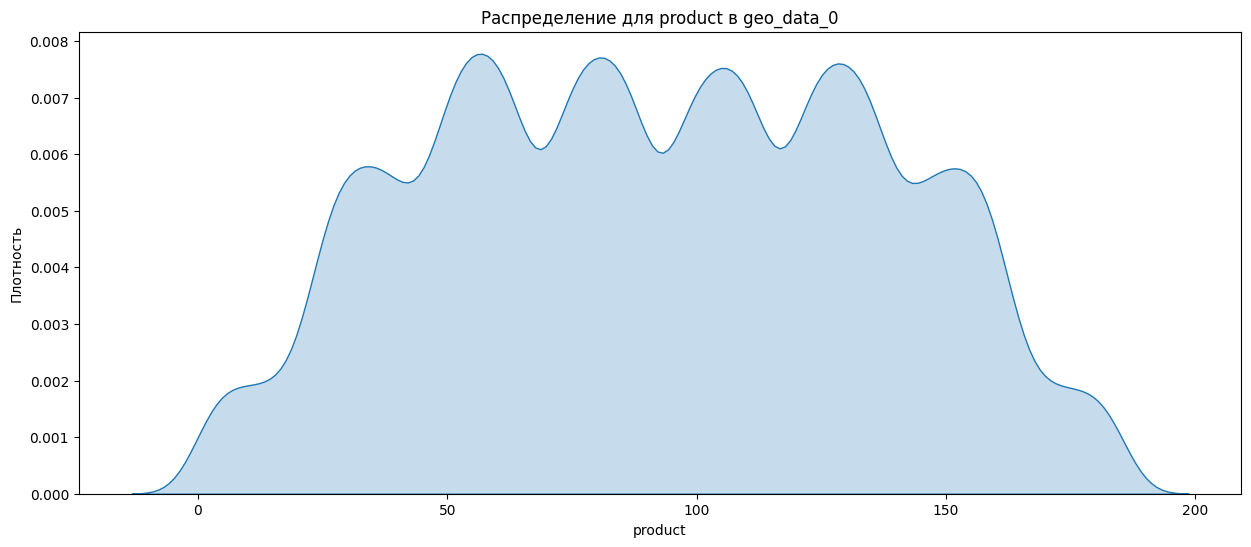

count    99980.000000
mean        92.499166
std         44.289044
min          0.000000
25%         56.496513
50%         91.847928
75%        128.564089
max        185.364347
Name: product, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


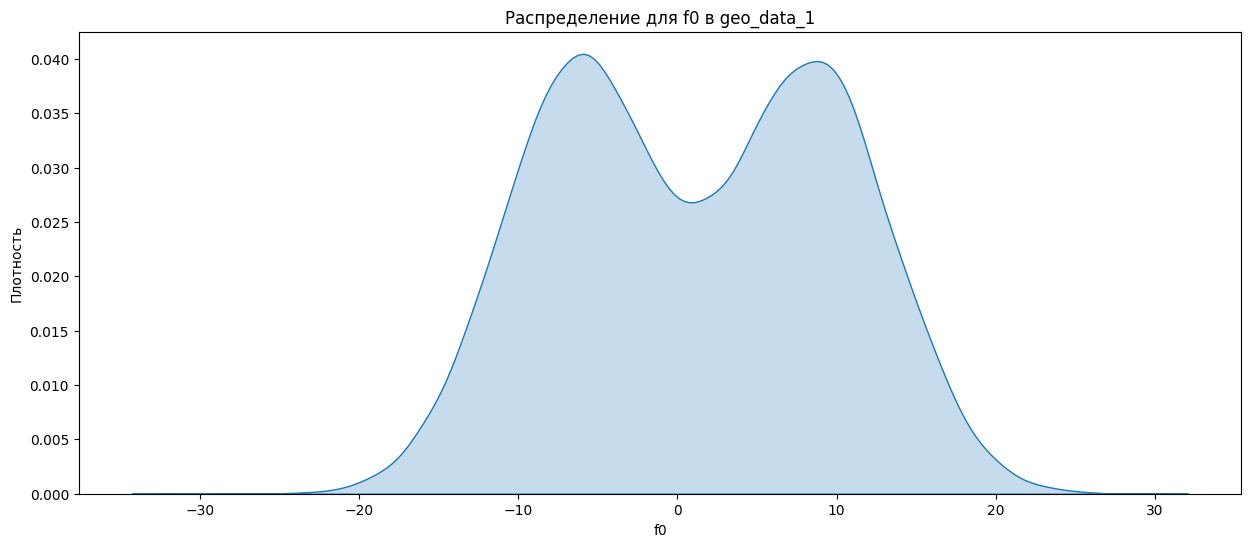

count    99992.000000
mean         1.141363
std          8.965805
min        -31.609576
25%         -6.298525
50%          1.153190
75%          8.620964
max         29.421755
Name: f0, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


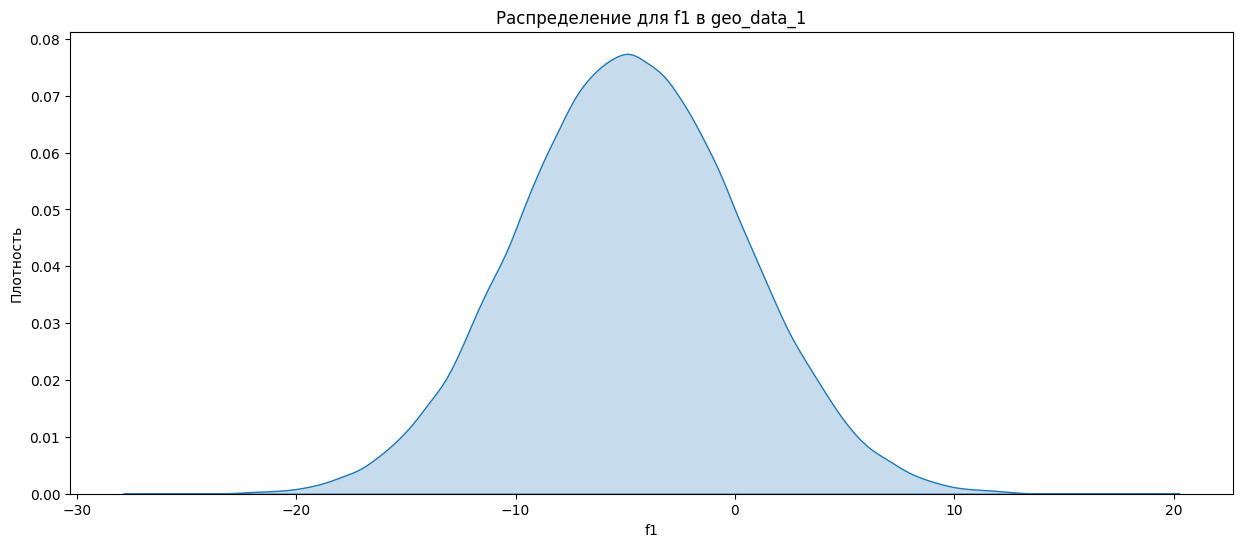

count    99992.000000
mean        -4.796522
std          5.119934
min        -26.358598
25%         -8.267985
50%         -4.813005
75%         -1.332704
max         18.734063
Name: f1, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


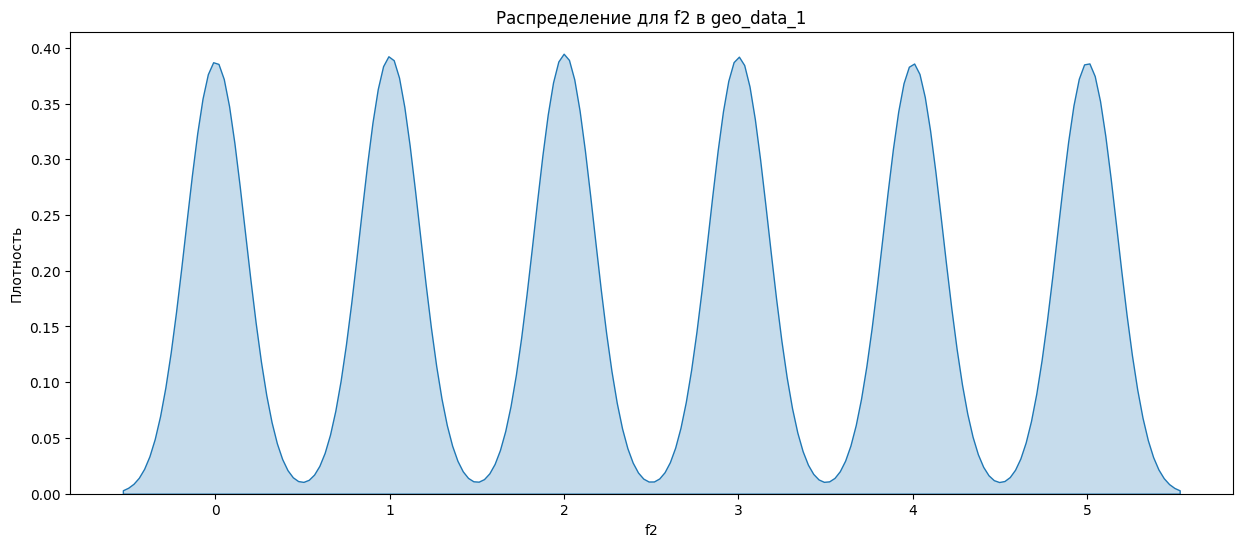

count    99992.000000
mean         2.494511
std          1.703587
min         -0.018144
25%          1.000021
50%          2.011475
75%          3.999904
max          5.019721
Name: f2, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


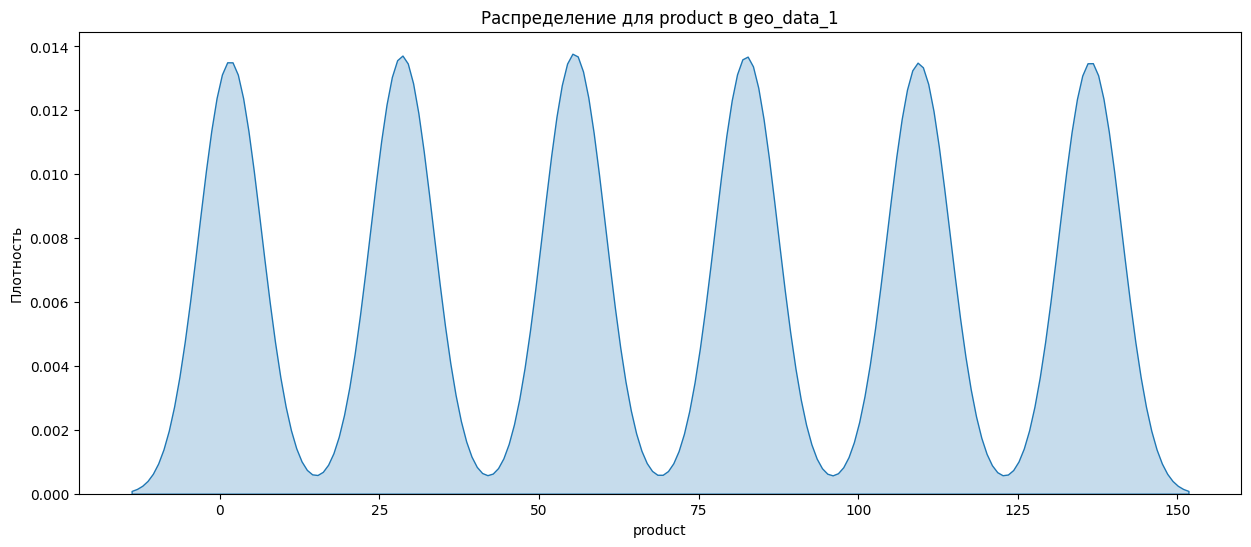

count    99992.000000
mean        68.824148
std         45.944889
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


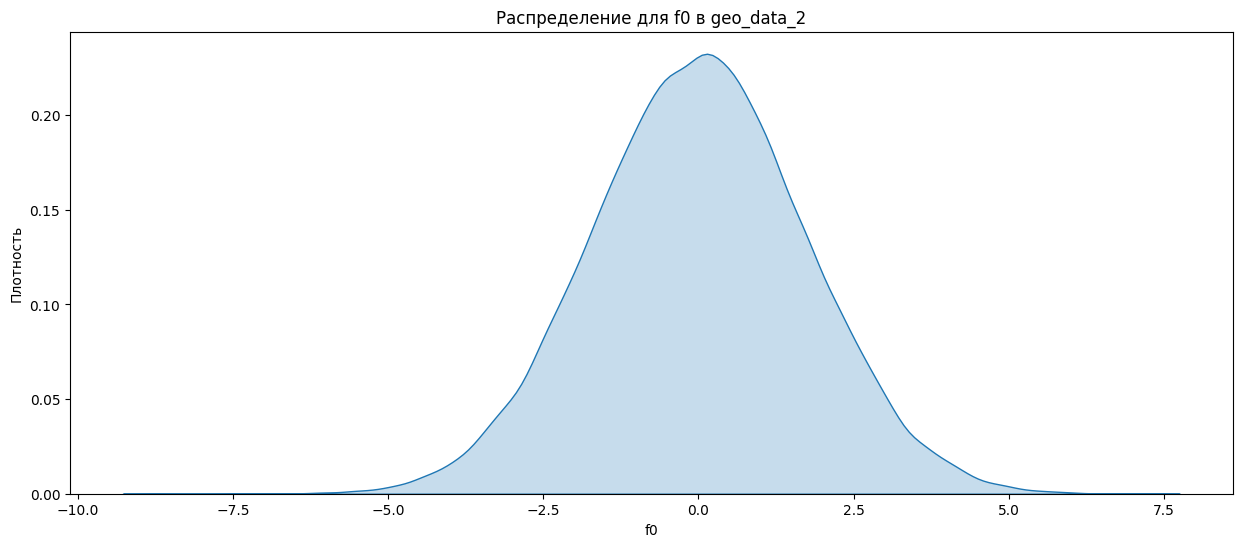

count    99992.000000
mean         0.001975
std          1.732061
min         -8.760004
25%         -1.162328
50%          0.009411
75%          1.158442
max          7.238262
Name: f0, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


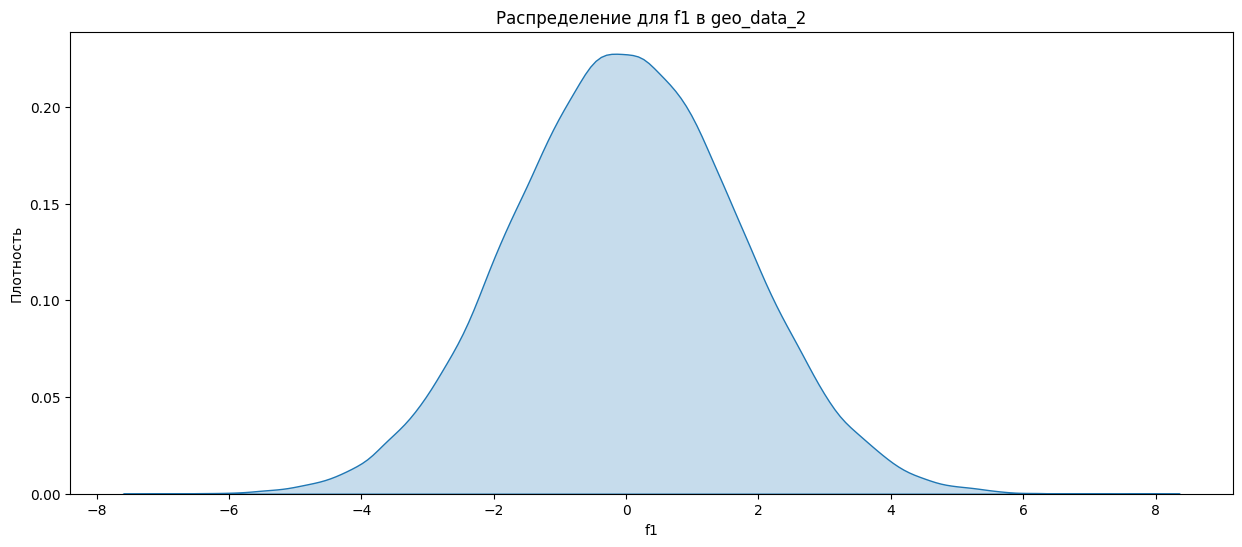

count    99992.000000
mean        -0.002113
std          1.730404
min         -7.084020
25%         -1.174820
50%         -0.009580
75%          1.163592
max          7.844801
Name: f1, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


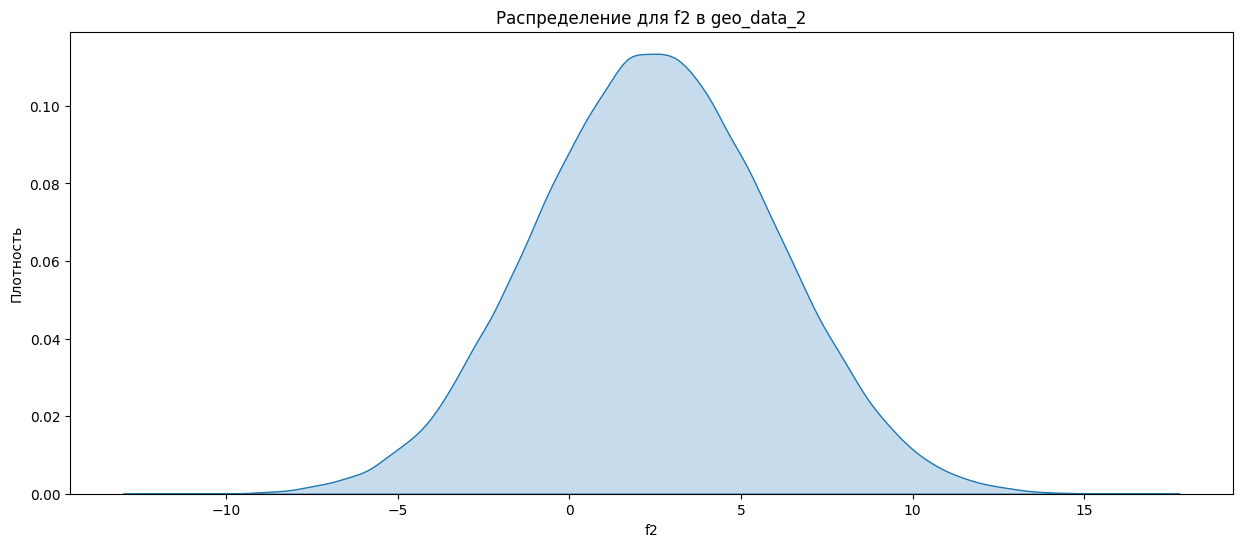

count    99992.000000
mean         2.495088
std          3.473491
min        -11.970335
25%          0.130269
50%          2.484236
75%          4.858662
max         16.739402
Name: f2, dtype: float64

/tmp/ipykernel_72947/1570061694.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


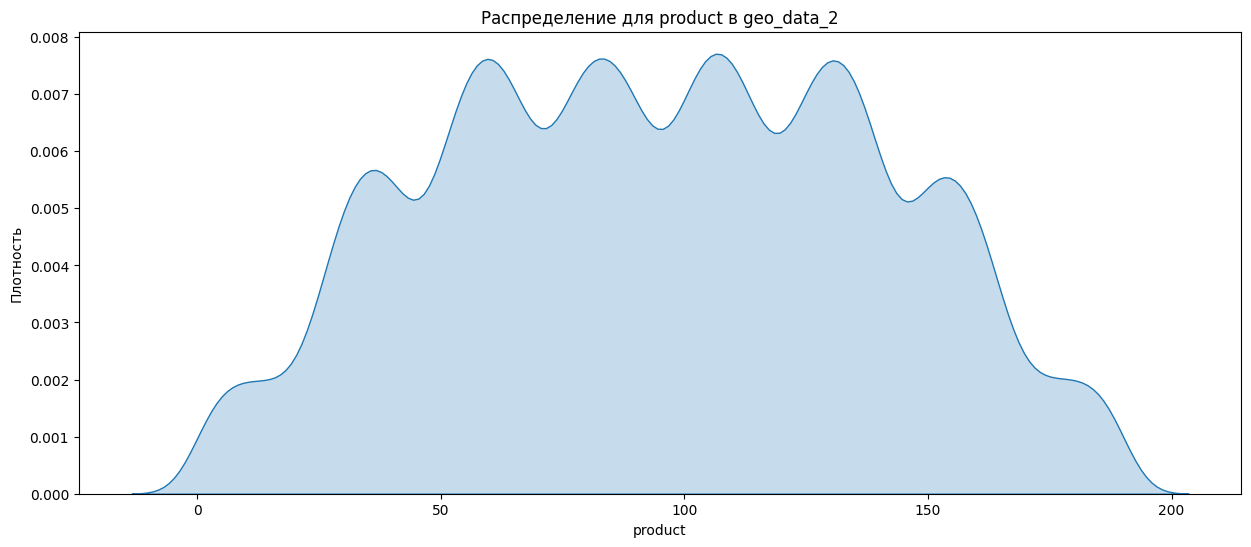

count    99992.000000
mean        94.998767
std         44.747763
min          0.000000
25%         59.450441
50%         94.925026
75%        130.585544
max        190.029838
Name: product, dtype: float64

In [10]:
for df in geo_data_0, geo_data_1, geo_data_2:
    for col in 'f0', 'f1', 'f2', 'product':
        
        plt.figure(figsize=(15,6))
        
        sns.kdeplot(
            df[col], 
            shade=True
        )
        
        plt.title(f'Распределение для {col} в {df.columns.name}')
        plt.xlabel(col)
        plt.ylabel('Плотность')
        
        plt.show()
        
        display(df[col].describe())
    
    print('=' * 100)

Для всех признаков есть сложные многомодальные распределения:
- для f0 - в geo_data_0 и geo_data_1
- для f1 - в geo_data_0 
- для f2 - в geo_data_1
Для целевой переменной тоже наблюдается сложное распределение.


Не стоит использовать методы, предполагающие нормальное распределение - например, считать коэффициенты корреляции по Пирсону.

При этом выбросов и аномалий нет - не будет проблем с линейными моделями. 

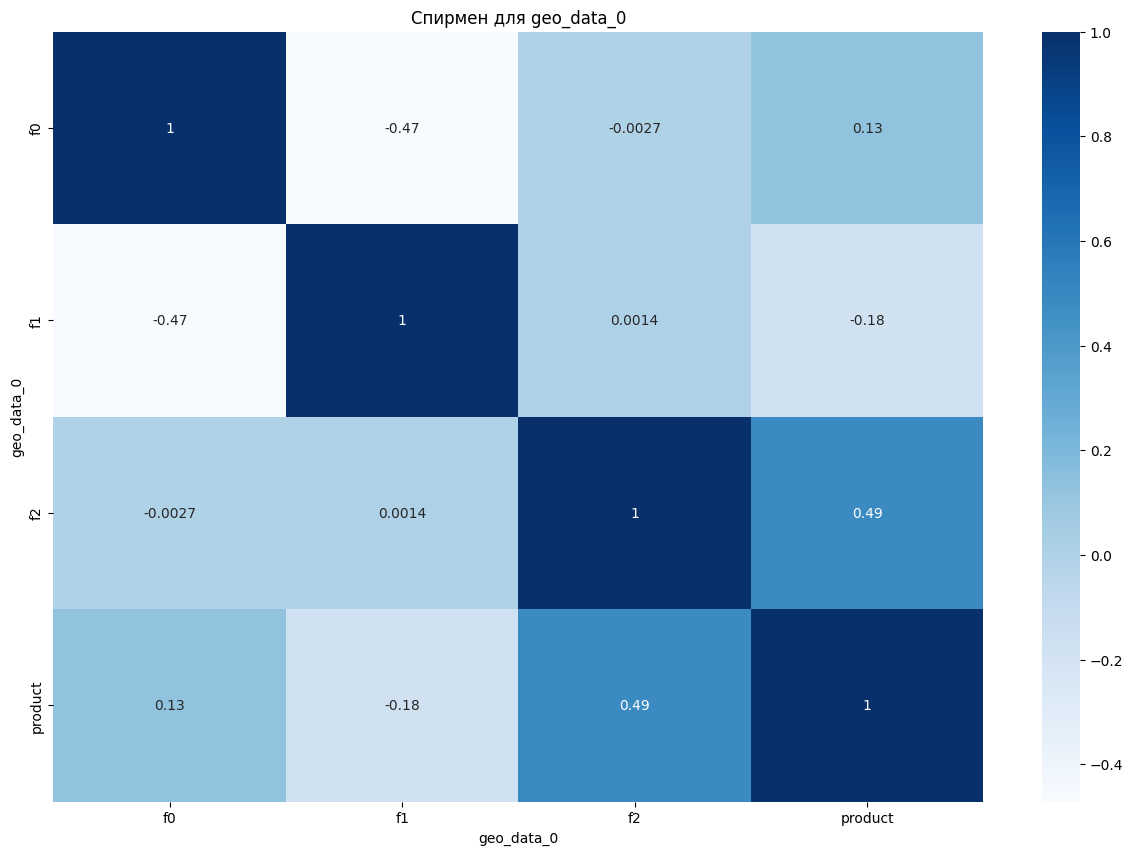

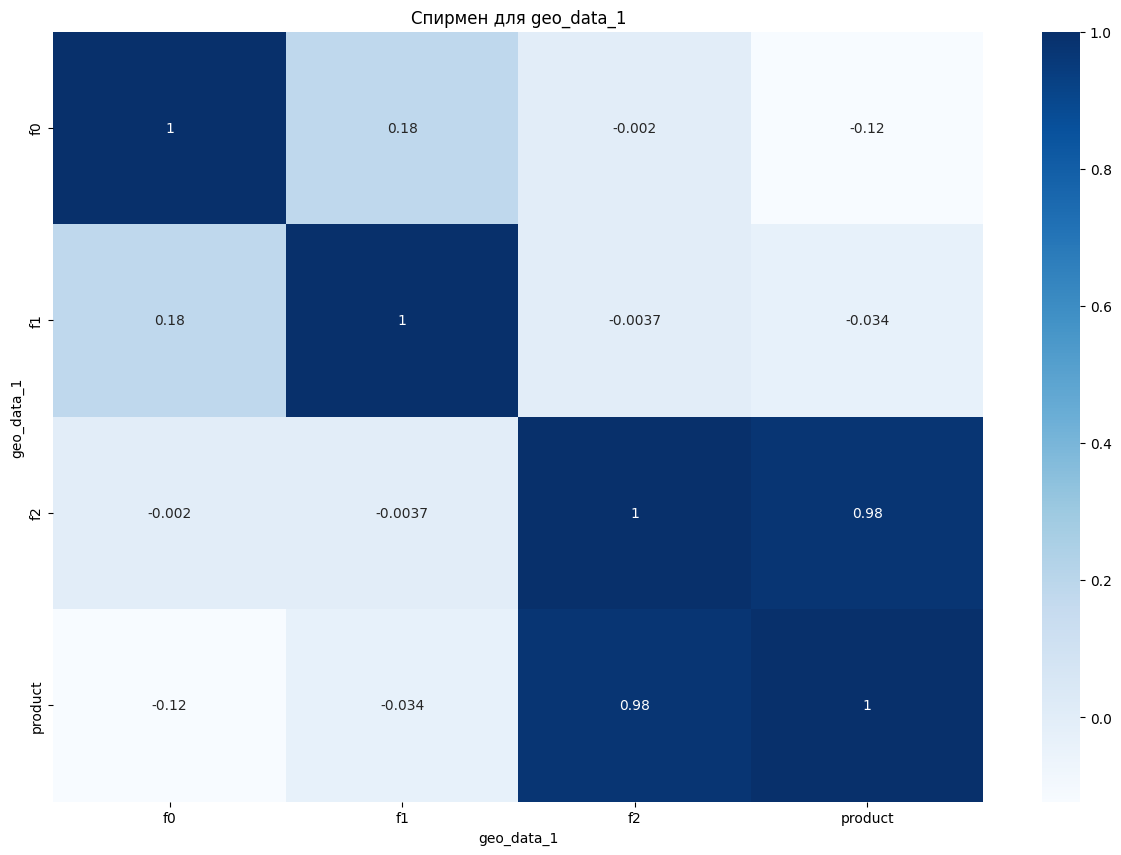

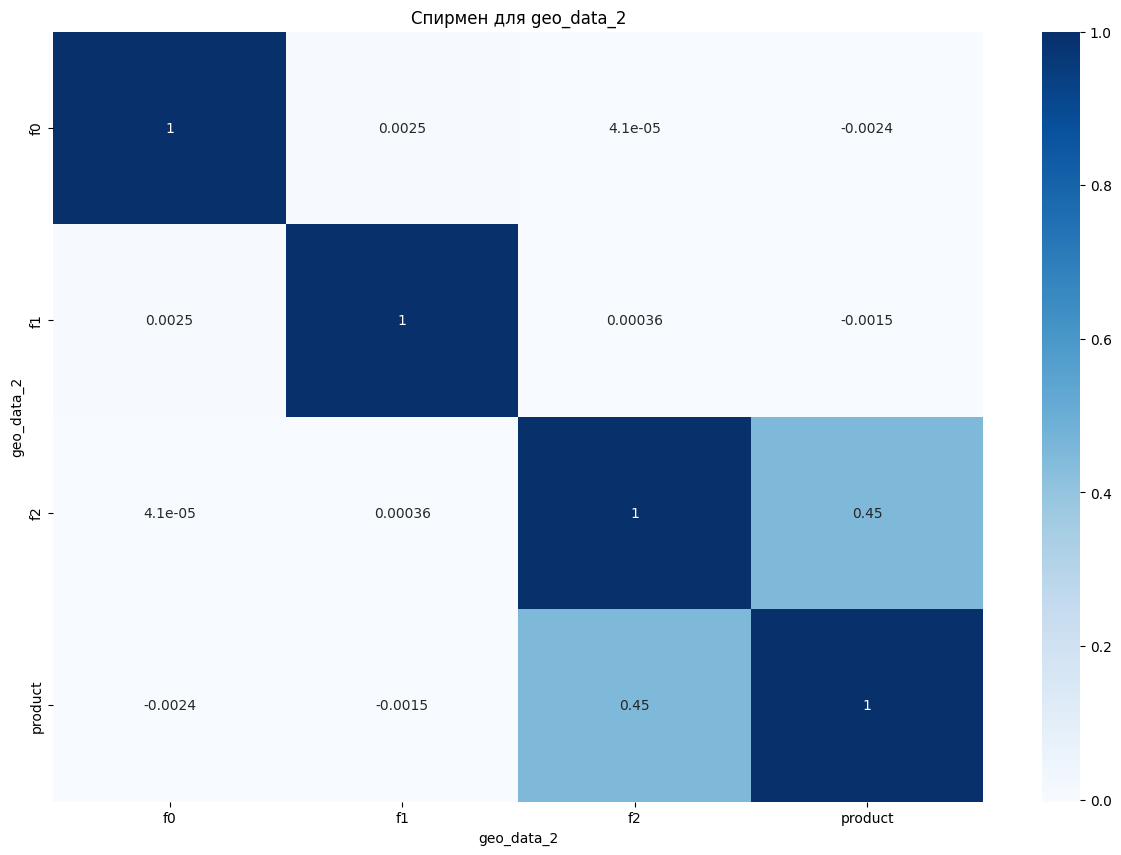

In [11]:
for df in geo_data_0, geo_data_1, geo_data_2:
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        df.drop('id', axis=1).corr(method='spearman'), 
        cmap="Blues", 
        annot=True
    )
    plt.title(f'Спирмен для {df.columns.name}')
    plt.show()

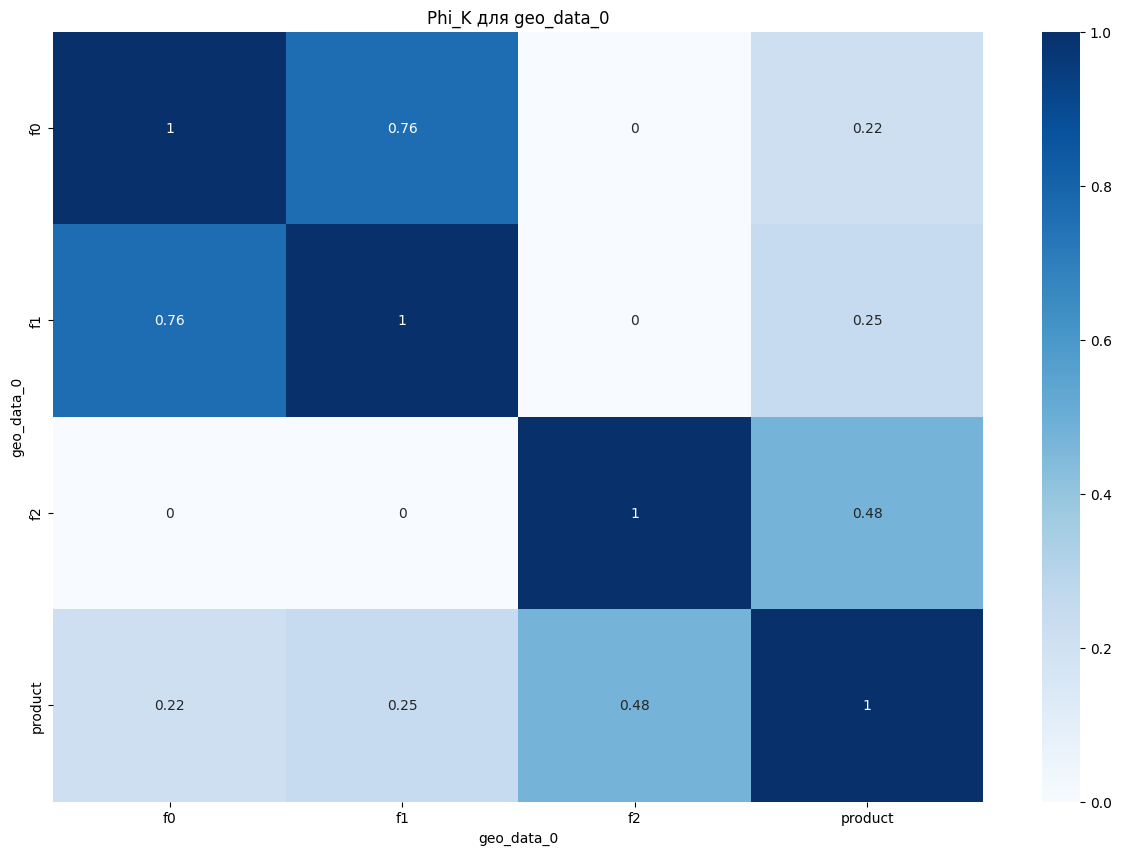

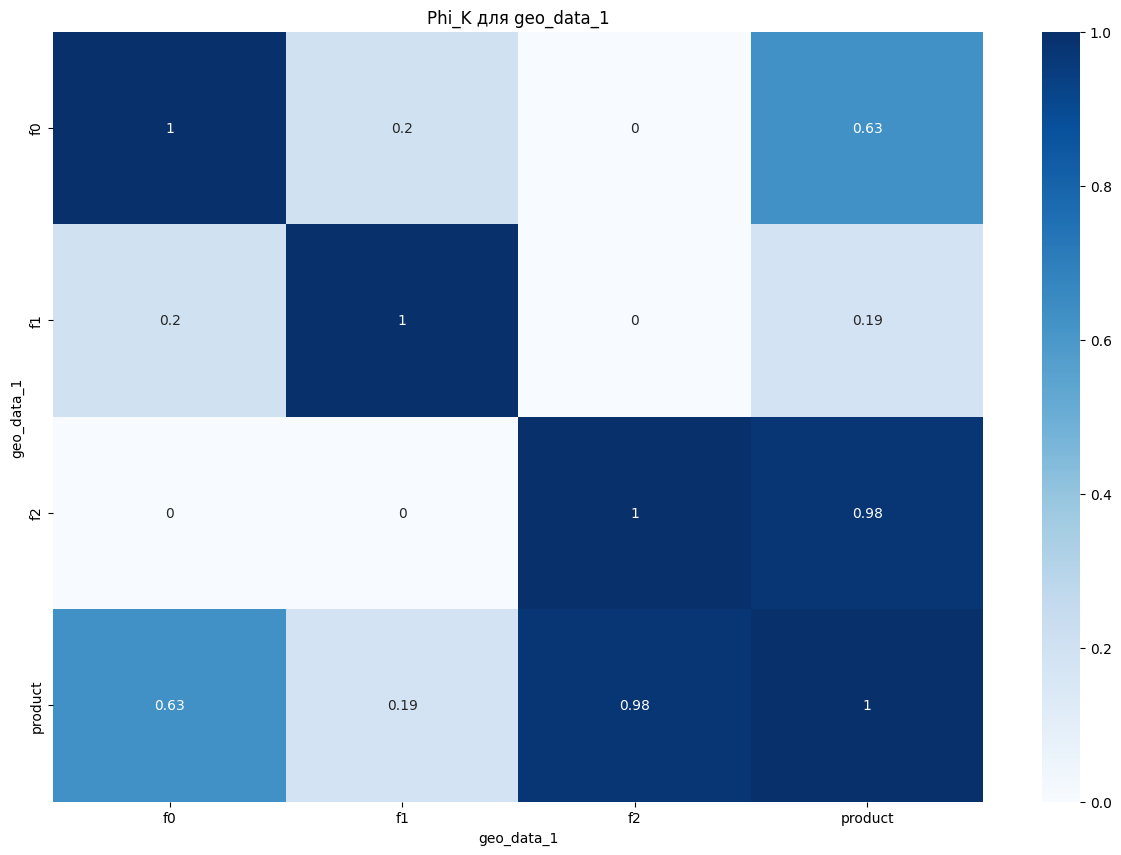

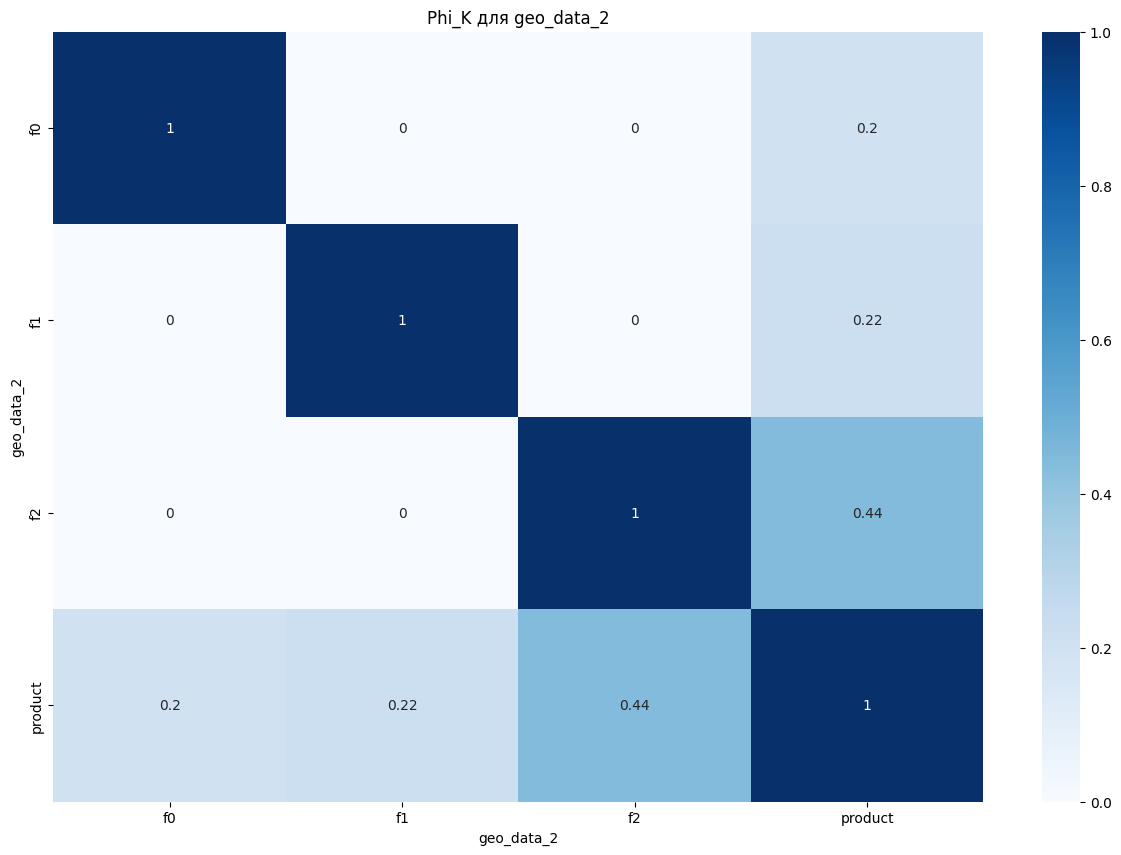

In [12]:
for df in geo_data_0, geo_data_1, geo_data_2:
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        df.drop('id', axis=1).phik_matrix(
            interval_cols=['f0', 'f1', 'f2', 'product']
        ), 
        cmap='Blues',
        annot=True
    )
    plt.title(f'Phi_K для {df.columns.name}')
    plt.show()

По Спирмену всё ок - больше 0.47 по модулю между принаками нет. Phi_K даёт высокую корреляцию между f0 и f1 в geo_data_0. 

### Итог

Данные готовы для обучения на них моделей

## Обучение и проверка модели

### Функции

In [13]:
def fit_and_validate(
    df
):
    '''
    разделение выборки на обучающую и тестовую/валидационную
    обучение
    тестирование
    печать метрик
    '''
    X = df[['f0', 'f1', 'f2']]
    y = df['product']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
    )
    
    scaler = MinMaxScaler()
    
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    model = LinearRegression()
    
    model.fit(X_train_sc, y_train)
    
    y_test_pred = model.predict(X_test_sc)
    
    print(f'R2: {r2_score(y_test, y_test_pred):.2f}')
    print('Коэффициенты: ', end='')
    for c in model.coef_:
        print(f'{c:.3f}', end=' ')
    print('\n')
    
    print(f'Средний запас: {y_test_pred.mean():.1f}')
    print(f'RMSE: {root_mean_squared_error(y_test, y_test_pred):.1f}')
    
    return y_test, y_test_pred

### Обучение

In [14]:
y_test_gd0, y_pred_gd0 = fit_and_validate(geo_data_0)

R2: 0.27
Коэффициенты: 14.556 -30.360 170.318 

Средний запас: 92.3
RMSE: 37.8


In [15]:
y_test_gd1, y_pred_gd1 = fit_and_validate(geo_data_1)

R2: 1.00
Коэффициенты: -8.847 -0.939 135.780 

Средний запас: 69.2
RMSE: 0.9


In [16]:
y_test_gd2, y_pred_gd2 = fit_and_validate(geo_data_2)

R2: 0.19
Коэффициенты: -0.863 -0.210 163.263 

Средний запас: 94.8
RMSE: 40.1


### Итог 
Для регионов 0 и 2 линейная модель даёт невысокую точность - низкий R2 и большая RMSE.
Вероятно, есть сильная нелинейная зависимость.
С другой стороны, для региона 1 данные укладываются в линейную модель практически идеально.
Во всех 3 регионах ключевым признаком является f2, что видно по величине коэффициентов.

## Подготовка к расчёту прибыли

In [17]:
# параметры

BOREHOLE_TOTAL = 500           # сколько мест для скважин будет исследовано
BOREHOLE_BEST = 200            # сколько скважин будет построено
BUDGET_TOTAL = 10_000_000_000. # суммарный бюджет на строительство BOREHOLE_BEST скажин
REVENUE_PER_PRODUCT = 450_000. # доход от 1 условной единицы (1 тысячи баррелей) добытого продукта

BOOTSTRAP_SAMPLES = 1000
QUANTILE_L = 0.025
QUANTILE_U = 0.975

In [18]:
print(f'Порог окупаемости: {BUDGET_TOTAL / BOREHOLE_BEST / REVENUE_PER_PRODUCT:.1f}')

Порог окупаемости: 111.1


Из скважины нужно добыть 111 тысяч баррелей, чтобы окупить затраты на её строительство.

### Итог 
Для регионов 0, 1 и 2 средний запас на скважину 92, 69 и 95 тысяч баррелей, что ощутимо ниже необходимых для окупаемости 111 тысяч

## Расчёт прибыли и рисков 

### Функции

In [19]:
def profit_sum(
    data,
    count
):
    '''
    считаем "реальный" доход для count лучших по предсказаниям модели
    '''
    data_sr = data.sort_values(by='pred', ascending=False)[:count]

    res = data_sr.test * REVENUE_PER_PRODUCT - BUDGET_TOTAL / BOREHOLE_BEST
    
    return res.sum()

### Bootstrap

Регион 0
2.5%-квантиль: -121426873.6
Средний доход: 405706852.8
97.5%-квантиль: 923795254.7
Вероятность убытков: 7.2%


<timed exec>:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



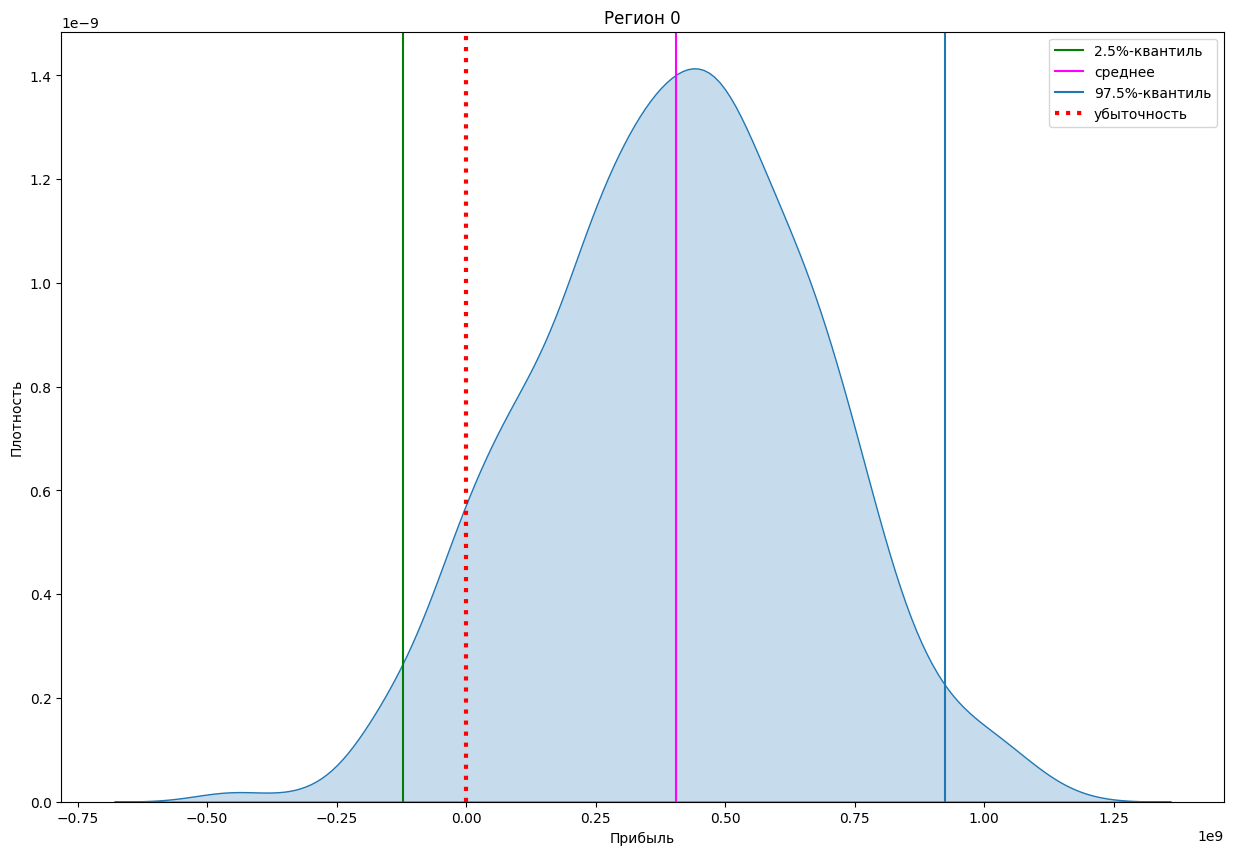


Регион 1
2.5%-квантиль: 65326279.9
Средний доход: 478871449.4
97.5%-квантиль: 861736053.5
Вероятность убытков: 0.5%


<timed exec>:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



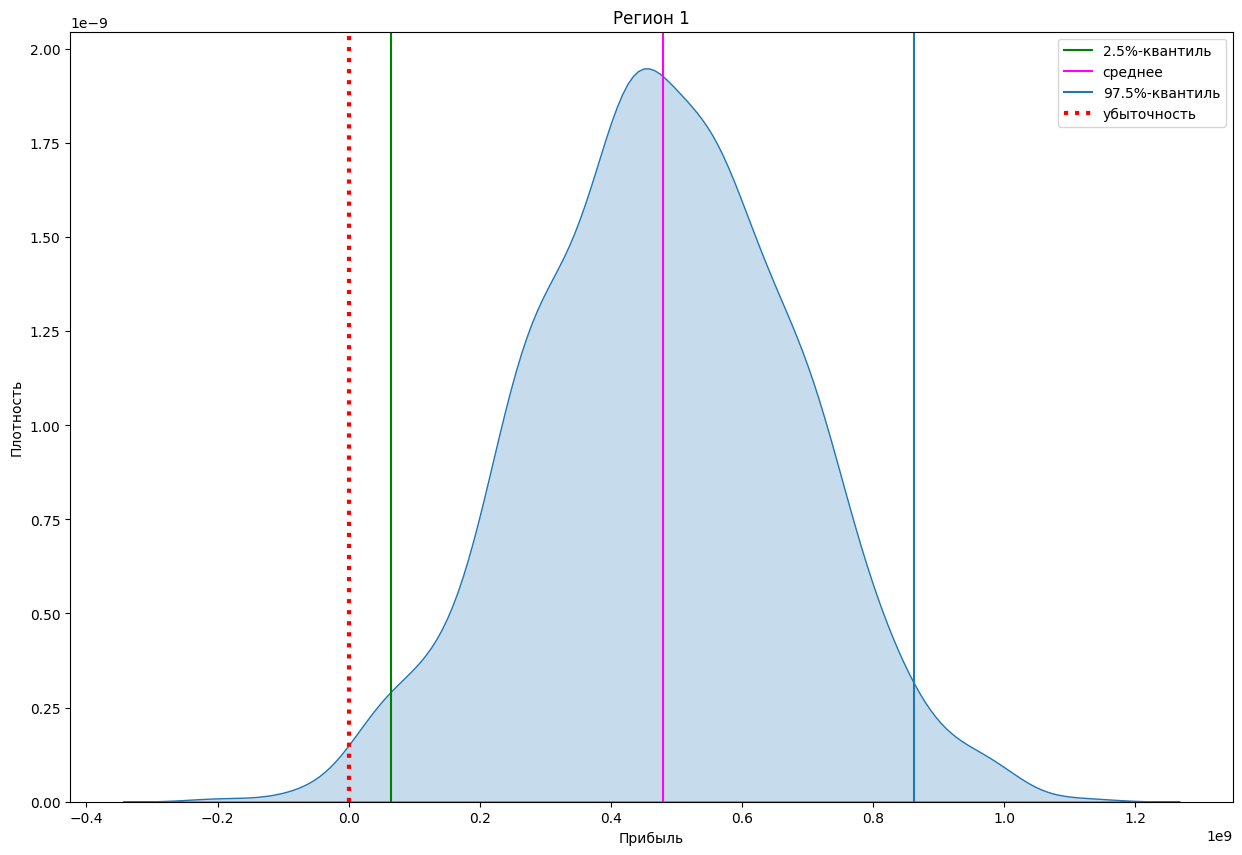


Регион 2
2.5%-квантиль: -206076346.8
Средний доход: 363047927.2
97.5%-квантиль: 862100485.7
Вероятность убытков: 9.0%


<timed exec>:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



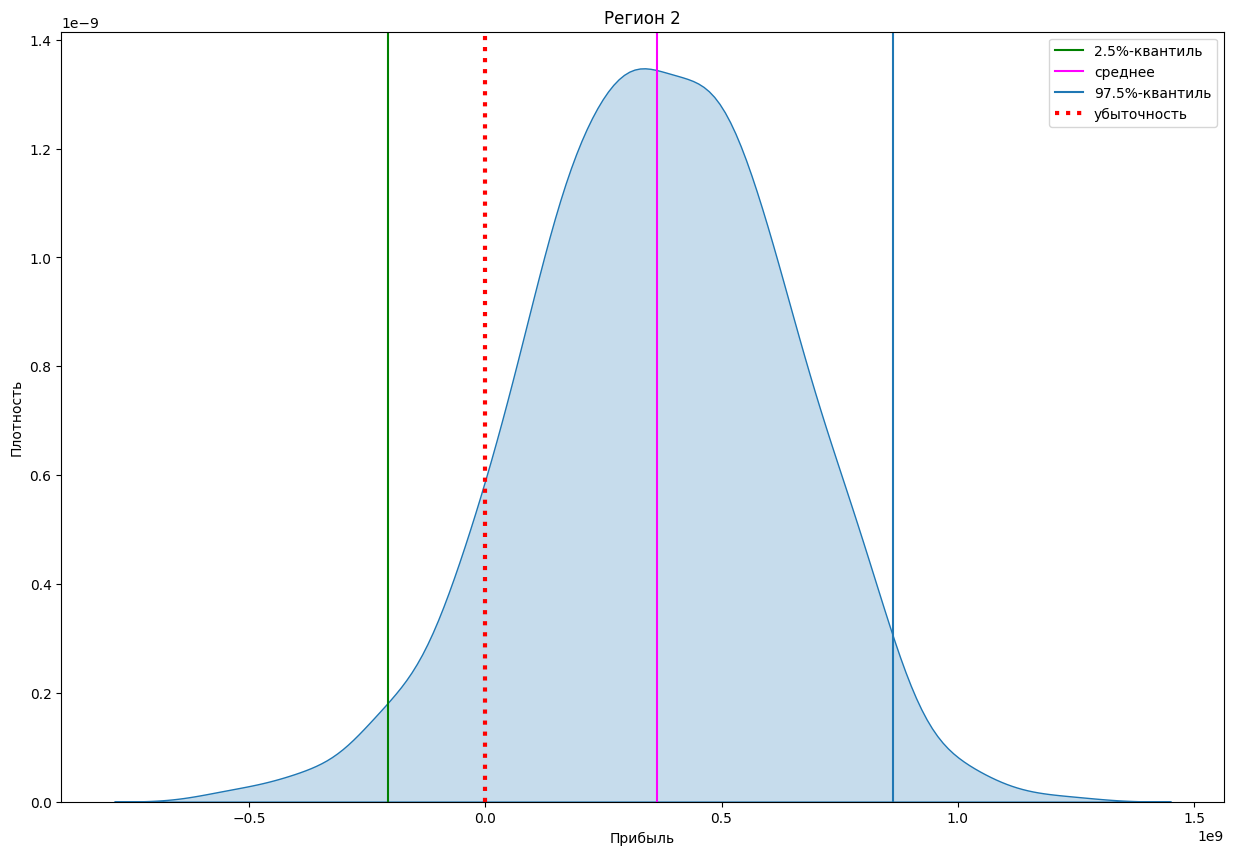


CPU times: user 1.59 s, sys: 266 ms, total: 1.85 s
Wall time: 1.34 s


In [20]:
%%time

for test, pred, reg in [
    (y_test_gd0, y_pred_gd0, 0),
    (y_test_gd1, y_pred_gd1, 1),
    (y_test_gd2, y_pred_gd2, 2)
]:
    data = pd.DataFrame()
    data['test'] = test.values
    data['pred'] = pred
    
    state = np.random.RandomState(RANDOM_STATE)
    
    best_profit = []
    
    for _ in range(BOOTSTRAP_SAMPLES):
                
        data_sample = data.sample(n=BOREHOLE_TOTAL, replace=True, random_state=state)
        best_profit.append(profit_sum(data_sample, BOREHOLE_BEST))
        
    best_profit = pd.Series(best_profit)
    
    quantile_l = best_profit.quantile(QUANTILE_L)
    quantile_u = best_profit.quantile(QUANTILE_U)
    
    mean = best_profit.mean()
    
    #вероятность убытков оценим, как долю выборок с отрицательной прибылью
    prob = best_profit[best_profit < 0].shape[0] / best_profit.shape[0]

    print('Регион', reg)
    print(f'{100 * QUANTILE_L}%-квантиль: {quantile_l:.1f}')
    print(f'Средний доход: {mean:.1f}')
    print(f'{100 * QUANTILE_U}%-квантиль: {quantile_u:.1f}')
    print(f'Вероятность убытков: {100 * prob:.1f}%')
    
    # добавим график - и правда будет очень кстати
    plt.figure(figsize=(15, 10))
    sns.kdeplot(
        best_profit, 
        shade=True
    ) 
    plt.axvline(
        quantile_l, 
        label=f'{100 * QUANTILE_L}%-квантиль',
        color='green'
    )
    plt.axvline(
        mean, 
        label='среднее',
        color='magenta'
    )
    plt.axvline(
        quantile_u, 
        label=f'{100 * QUANTILE_U}%-квантиль'
    )
    
    plt.axvline(
        0, 
        label='убыточность',
        color='red',
        ls=':',
        lw=3
    )
    
    plt.title(f'Регион {reg}')
    plt.xlabel('Прибыль')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()
    
    print()

### Итог
Самым лучшим регионом для разработки выглядит регион 1 - для него самые высокие значения среднего и положительное значение квантиля 2.5%.
Также для этого региона самая низкая вероятность убытков - меньше 1%.
Для регионов 0 и 2 эта веротяность уже порядка 10%.